In [1]:
import jax
import jax.numpy as jnp

### Force CPU usage

Making the algorithm work on GPU is left for future work.

In [2]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


Jax runs in `float32` by default, which is not enough precision for our purposes. We force it to `float64` instead.

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
from variables import VariablePartition
from function_basis import HatFunctions
from kernels import GaussianKernel
from constraints import NoConstraints
from additive_gp import MaxModeAdditiveGaussianProcess

## Example in 2D

We rely on the illustration p2 of the paper [1].

[1] López-Lopera, A., Bachoc, F. and Roustant, O., 2022.
    *High-dimensional additive Gaussian processes under monotonicity constraints.*
    Advances in Neural Information Processing Systems, 35, pp.8041-8053.

In [5]:
x_train = jnp.array([[0.5, 0.], [0.5, 0.5], [0.5, 1.], [0., 0.5], [1., 0.5]])

def y_ground_truth(x):
  return 4 * (x[:,0] - 0.5)**2 + 2 * x[:,1]

y_train = y_ground_truth(x_train)
y_train

2023-08-22 18:18:52.863994: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([0., 1., 2., 2., 2.], dtype=float64)

In [6]:
# discretize [0, 1]^2 with 50 points in each direction
knots = jnp.linspace(0, 1, 50)
x1, x2 = jnp.meshgrid(knots, knots)
x_test = jnp.stack([x1.flatten(), x2.flatten()], axis=1)
y_test = y_ground_truth(x_test)

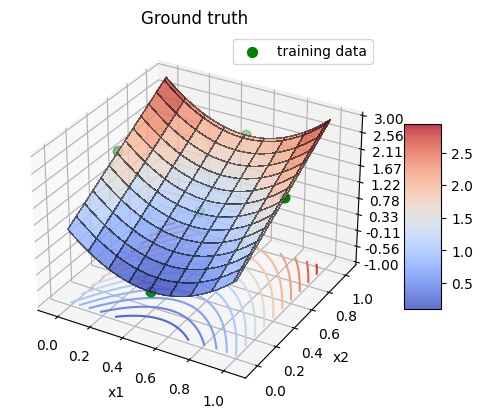

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

def plot_surface_3d(x1, x2, y, x_train, y_train, fig, ax, title=""):
  edgecolor = (0.1, 0.1, 0.1, 0.6)
  surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                        linewidth=0.3, antialiased=False,
                        edgecolor=edgecolor,
                        rstride=4, cstride=6,
                        alpha=0.8)
  ax.contour(x1, x2, y, zdir='z', offset=-1, cmap='coolwarm', levels=15)
  ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), zlim=(-1, 3),
         xlabel='x1', ylabel='x2', zlabel='y')
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter('{x:.02f}')
  ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='green', s=50, label='training data')
  ax.legend()
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.set_title(title)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot_surface_3d(x1, x2, y_test.reshape(x1.shape), x_train, y_train, fig, ax, "Ground truth")

First, we rely on conventional Gaussian process regression, so we assume joint effects (no additive structure),
and we do not impose monotonicity or convexity constraints.

### Step by step creation of toy example.

1) We start with a discretization of the domain.

In [8]:
from variables import isotropic_block  # helper function to create a block of variables

block = isotropic_block(names='xy', indices=[0, 1], domain=(0, 1), num_ticks=5)  # hypercube in [0, 1]^2 with 5 subdivisions in each direction.

2) We build a trivial partition that consists of a single block.

In [9]:
partition = VariablePartition([block])

3) For the basis of functions, we rely on Hat functions thanks to their simplicity and their ability to be combined to form more complex functions.

In [10]:
basis = HatFunctions(max_value=1.0)

4. We use the so-called Gaussian kernel, or RBF (that stands for "Radial Basis Functions") defined as:
$$k(x,y)=\exp{\left(-\frac{\|x-y\|^2_2}{l^2}\right)}$$
Note that this multivariate kernel is indeed a product of univariate kernels:
$$k(x,y)=\prod_{i=1}^d k(x_i,y_i)$$
where $k(x_i,y_i)=\exp{\left(-\frac{(x_i-y_i)^2}{l^2}\right)}$ is the univariate kernel for the $i$-th dimension.

In [11]:
kernel = GaussianKernel(length_scale=1.)

5. We consider a very simple Gaussian process without any constraints on the learned functions.

In [12]:
constraints = NoConstraints()

6. We are now ready to go! The model is fully defined.

In [13]:
monoblock_gp = MaxModeAdditiveGaussianProcess(partition, basis, kernel, constraints)

We fit the model:

In [14]:
additive_fun = monoblock_gp.fit(x_train, y_train)

We used the additive GP to predict labels on new entries.

In [15]:
structured_pred = additive_fun.predict(x_train)
structured_pred

StructuredPrediction(y_pred=Array([8.90676110e-04, 1.04011452e+00, 1.99582057e+00, 1.97832722e+00,
       1.97832722e+00], dtype=float64), y_pred_per_block=[Array([8.90676110e-04, 1.04011452e+00, 1.99582057e+00, 1.97832722e+00,
       1.97832722e+00], dtype=float64)])

We are interested on the final prediction to compute the metrics. The `y_pred_per_block` fields is here for debugging purpose.

In [16]:
y_pred = structured_pred.y_pred

Let's compute some metrics on the train set and the test set!

In [17]:
from utils import regression_report
regression_report(y_train, y_pred)  # train set

Mean absolute error: 0.0177
Mean relative error: 0.0130%
Explained variance score: 99.9201%


,0,1,2,3,4
absolute_error,0.000891,0.040115,0.004179,0.021673,0.021673
relative_error,0.000891,0.040115,0.002090,0.010836,0.010836


In [18]:
y_pred = additive_fun.predict(x_test).y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean absolute error: 0.0571
Mean relative error: 0.0953%
Explained variance score: 99.1919%


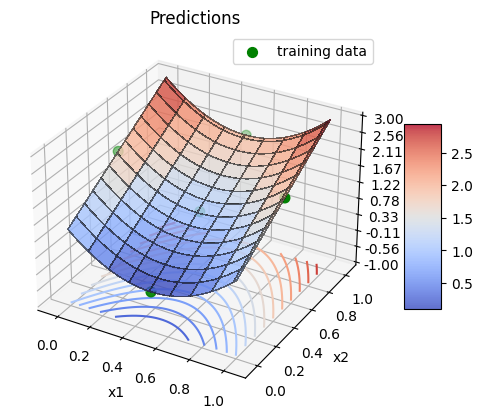

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, fig, ax, "Predictions")

### Additive structure

We now assume there exists an additive structure, such that:
$$Y(x_1,x_2) = Y_1(x_1) + Y(x_2).$$

We reflect this by modifying appropriately the partition variable so that it contains two disjoint blocks of one variable each.

In [20]:
from variables import block_1D

block_1 = block_1D(name='x1', index=0, domain=(0., 1.), num_ticks=10)
block_2 = block_1D(name='x2', index=1, domain=(0., 1.), num_ticks=10)
partition = VariablePartition([block_1, block_2])

In [21]:
monoblock_gp = MaxModeAdditiveGaussianProcess(partition, basis, kernel, constraints)
additive_fun = monoblock_gp.fit(x_train, y_train)
y_pred = additive_fun.predict(x_train).y_pred
regression_report(y_train, y_pred)  # train set

Mean absolute error: 0.0165
Mean relative error: 0.0124%
Explained variance score: 99.9306%


,0,1,2,3,4
absolute_error,0.00152,0.039725,0.006590,0.017305,0.017305
relative_error,0.00152,0.039725,0.003295,0.008652,0.008652


In [22]:
y_pred = additive_fun.predict(x_test).y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean absolute error: 0.0331
Mean relative error: 0.0342%
Explained variance score: 99.7037%


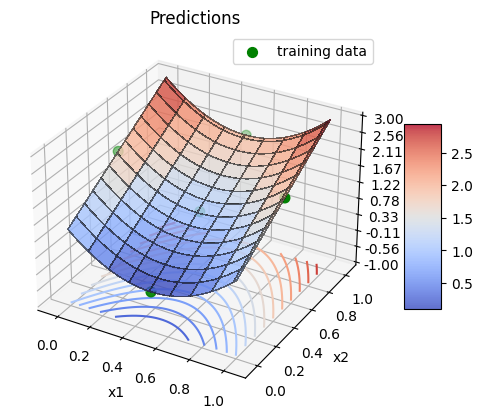

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, fig, ax, "Predictions")

### Simple constraint

The next step on our journey is to incorporate constraints. Let's see what happens with a bounded constraint, a bit too harsh for our problem.

In [24]:
from constraints import BoundedConstraints

constraints = BoundedConstraints(min_value=0., max_value=1.)